In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import norm
from scipy.stats import f

In [2]:
df = pd.read_csv('conjunto_de_datos_tmodulo_enut_2019.csv',encoding='latin-1')
df_nuevo = df[['EDAD_V','SEXO','NIV','P5_1','P5_3_1','P5_3_2','P5_3_3','P5_3_4','P5_6_6','P5_7','P5_7A','P6_10_7','P_6_13_3','P6_13_5','P6_13_6','P6_10_7','P6_8_2','P6_6_3','P6_5_2','P6_4_3']]

In [3]:
df_nuevo['P5_3_1'] = df_nuevo['P5_3_1'].replace({np.nan: '0'})
df_nuevo['P5_3_2'] = df_nuevo['P5_3_2'].replace({np.nan: '0'})
df_nuevo['P5_3_3'] = df_nuevo['P5_3_3'].replace({np.nan: '0'})
df_nuevo['P5_3_4'] = df_nuevo['P5_3_4'].replace({np.nan: '0'})
df_nuevo['P5_7'] = df_nuevo['P5_7'].replace({np.nan: '0'})
df_nuevo['P5_7'] = df_nuevo['P5_7'].replace({'99999': '0'})
df_nuevo['P5_7A'] = df_nuevo['P5_7A'].replace({np.nan: '-1'})
df_nuevo['P5_3_1'] = df_nuevo['P5_3_1'].astype(int)
df_nuevo['P5_3_2'] = df_nuevo['P5_3_2'].astype(int)
df_nuevo['P5_3_3'] = df_nuevo['P5_3_3'].astype(int)
df_nuevo['P5_3_4'] = df_nuevo['P5_3_4'].astype(int)
df_nuevo['P5_7'] = df_nuevo['P5_7'].astype(float)
df_nuevo['P5_7A'] = df_nuevo['P5_7A'].astype(int)
df_nuevo['tot_horas'] = df_nuevo['P5_3_1'] + df_nuevo['P5_3_3']
df_nuevo['tot_minutos'] = df_nuevo['P5_3_2'] + df_nuevo['P5_3_4']
df_nuevo['tot_horas'] = df_nuevo['tot_horas'] + (df_nuevo['tot_minutos']/60)

C:\Users\Miguel\AppData\Local\Temp/ipykernel_17760/1619613471.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nuevo['P5_3_1'] = df_nuevo['P5_3_1'].replace({np.nan: '0'})
C:\Users\Miguel\AppData\Local\Temp/ipykernel_17760/1619613471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nuevo['P5_3_2'] = df_nuevo['P5_3_2'].replace({np.nan: '0'})
C:\Users\Miguel\AppData\Local\Temp/ipykernel_17760/1619613471.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [4]:
df_nuevo = df_nuevo.loc[df_nuevo['P5_7'] > 0]
df_nuevo = df_nuevo.loc[df_nuevo['P5_7A'] > 0]
df_nuevo = df_nuevo.loc[df_nuevo['EDAD_V'] >= 15]
df_nuevo = df_nuevo.loc[df_nuevo['P5_1'] == 1]

In [5]:
def agregaColFrecPago(df):
    res = []
    for x in df:
        if x == 1:
            res.append(52)
        else:
            if x == 2:
                res.append(26)
            else:
                if x == 3:
                    res.append(12)
                else:
                    res.append(1)
    
    return res
x = agregaColFrecPago(df_nuevo['P5_7A'])
df_nuevo['semanal'] = ((x * df_nuevo['P5_7'])/48)
df_nuevo['ganancia_hora'] = df_nuevo['semanal']/df_nuevo['tot_horas']
df_nuevo = df_nuevo.loc[df_nuevo['P5_6_6'] == 1]
df_limitado = df_nuevo.loc[df_nuevo['ganancia_hora'] <= 500]
df_limitado = df_limitado.loc[df_limitado['tot_horas'] <= 90]

## Metodos para agrupamiento de datos

In [6]:
def grupos(df,minimo,maximo,num_grupos):
    minimo = minimo - 1
    maximo = maximo + 1
    dif = maximo - minimo
    tam_grupo = dif/num_grupos
    res = []
    for x in df:
        y = x - minimo
        y = int(y/tam_grupo)
        if y % tam_grupo == 0:
            if y != 0:
                y = y - 1
        res.append(y)
    return res

def imprimeGrupo(minimo,maximo,num_grupos):
    minimo = minimo - 1
    maximo = maximo + 1
    dif = maximo - minimo
    tam_grupo = dif/num_grupos
    for i in range(num_grupos):
        st = 'grupo '
        x = minimo + i * tam_grupo
        y = minimo + (i + 1) * tam_grupo
        print('grupo ' + str(i) + ': (' + str(x) + ',' + str(y) +']')

## Metodos para varianza y cosas extra

In [7]:
def s2df(df):
    
    n = len(df)
    media = np.mean(df)
    s2 = df - media
    s2 = np.dot(s2,s2)
    s2 = s2 / (n-1)
    
    return s2

def arrInterConfianza(metodo,arr,alfa):
    res = []
    for x in arr:
        
        res.append(metodo(x,alfa))
        
    return res

def arrEstimador(metodo,vec,col):
    res = []
    for x in vec:
        res.append(metodo(x[col]))
        
    return res

def pow_n(a):
    res = pow(a,1/2)
    
    return res

## Metodos para intervalos de confianza

In [8]:
def intervaloDeConfVarDesc(df,alfa):
    
    res = []
    n = len(df)
    grados_de_libertad = n - 1
    media = np.mean(df)
    s2 = s2df(df)
    res_t = t.ppf(1-alfa/2, df=grados_de_libertad)
    sn = s2 / n
    sn = pow(sn,1/2)
    res.append((media - sn * res_t))
    res.append((media + sn * res_t))
    
    return res

def intervaloDeConfDifMedias(x,alfa):
    
    res = []
    df_1 = x[0]
    df_2 = x[1]
    n1 = len(df_1)
    n2 = len(df_2)
    grados_de_libertad = n1 + n2 - 2
    media1 = np.mean(df_1)
    media2 = np.mean(df_2)
    dif = media1 - media2
    s21 = s2df(df_1)
    s22 = s2df(df_2)
    s1 = pow(s21,1/2)
    s2 = pow(s22,1/2)
    s2p = (((n1-1) * s21) + ((n2-1) * s22))/grados_de_libertad
    sp = pow(s2p,1/2)
    rn = (1/n1) + (1/n2)
    rn = pow(rn,1/2)
    res_t = t.ppf(1-alfa/2, df=grados_de_libertad)
    res.append((dif - res_t * sp * rn))
    res.append((dif + res_t * sp * rn))
    
    return res

def intervaloDeConfCocienteDeVar(vec,alfa):
    
    res = []
    
    df_1 = vec[0]
    df_2 = vec[1]
    
    n1 = len(df_1)
    n2 = len(df_2)
    
    s21 = s2df(df_1)
    s22 = s2df(df_2)
    
    f_res_sup = f.ppf(1-(alfa/2),n1-1,n2-1)
    
    f_res_inf = f.ppf(1-(alfa/2),n2-1,n1-1)
    f_res_inf = 1/f_res_inf
    
    cociente = s22/s21
    
    res.append(f_res_inf * cociente)
    res.append(f_res_sup * cociente)
    
    return res

## Metodos para pruebas de hipotesis

In [9]:
def pruebaDeHipotesisDifMediaInferior(h0,vec,alfa):
    
    df_0 = vec[0]
    df_1 = vec[1]
    
    media_0 = np.mean(df_0)
    media_1 = np.mean(df_1)
    
    n0 = len(df_0)
    n1 = len(df_1)
    
    s2_0 = s2df(df_0)
    s2_1 = s2df(df_1)
    
    dif = media_0 - media_1
    grados_de_libertad = n0 - n1 - 2
    
    sp2 = ((n0-1) * s2_0 + (n1-1) * s2_1)/grados_de_libertad
    sp = pow(sp2,1/2)
    
    nr2 = (1/n0) + (1/n1)
    nr = pow(nr2,1/2)
    
    t_res = t.ppf(alfa, df=grados_de_libertad)
    
    c = (t_res * nr * sp) + h0
    
    res_t = t.ppf(1-alfa/2, df=grados_de_libertad)
    
    return c,dif,c>dif

def pruebaDeHipotesisSuperior(h0,vec,alfa):
    
    media = np.mean(vec) 
    n = len(vec)    
    s2 = s2df(vec)    
    grados_de_libertad = n - 1
    s2n = s2/n
    sn = pow(s2n,1/2)
    
    t_res = t.ppf(1-alfa, df=grados_de_libertad)
    
    c = (t_res * sn) + h0
    
    return c,media,c<media


def pruebaDeHipotesisDifMediaSuperior(h0,vec,alfa):
    
    df_0 = vec[0]
    df_1 = vec[1]
    
    media_0 = np.mean(df_0)
    media_1 = np.mean(df_1)
    
    n0 = len(df_0)
    n1 = len(df_1)
    
    s2_0 = s2df(df_0)
    s2_1 = s2df(df_1)
    
    dif = media_0 - media_1
    grados_de_libertad = n0 - n1 - 2
    
    sp2 = ((n0-1) * s2_0 + (n1-1) * s2_1)/grados_de_libertad
    sp = pow(sp2,1/2)
    
    nr2 = (1/n0) + (1/n1)
    nr = pow(nr2,1/2)
    
    t_res = t.ppf(1-alfa, df=grados_de_libertad)
    
    c = (t_res * nr * sp) + h0
    
    return c,dif,c<dif

def beta(vec,punto_critico,ha):
    df_0 = vec[0]
    df_1 = vec[1]  
    
    n0 = len(df_0)
    n1 = len(df_1)
    
    s2_0 = s2df(df_0)
    s2_1 = s2df(df_1)
    
    grados_de_libertad = n0 - n1 - 2
    
    arriba = punto_critico - ha
    
    sp2 = ((n0-1) * s2_0 + (n1-1) * s2_1)/grados_de_libertad
    sp = pow(sp2,1/2)
    
    nr2 = (1/n0) + (1/n1)
    nr = pow(nr2,1/2)
    
    res = arriba/(sp*nr)
    
    t_res = t.cdf(res, df=grados_de_libertad)
    
    return t_res

def aceptar_o_rechazar_h0(b, alfa):
    
    if b :
        print('Hay evidencia suficiente para rechazar h0, con una confiabilidad del ' + str(1-alfa))
        
    else:
        print('No hay evidencia suficiente para rechazar h0, con una confiabilidad del ' + str(1-alfa))

# Intervalos de confianza

In [10]:
df_nula = df_nuevo.loc[df_nuevo['NIV'] == 0]
df_basica = df_nuevo.loc[df_nuevo['NIV'] > 0]
df_basica = df_basica.loc[df_basica['NIV'] < 4]
df_media = df_nuevo.loc[df_nuevo['NIV'] > 3]
df_media = df_media.loc[df_media['NIV'] < 8]
df_superior = df_nuevo.loc[df_nuevo['NIV'] > 7]

alfa = .05
arr_horas = [df_nula['tot_horas'],df_basica['tot_horas'],df_media['tot_horas'],df_superior['tot_horas']]
arr_pago_hora = [df_nula['ganancia_hora'],df_basica['ganancia_hora'],df_media['ganancia_hora'],df_superior['ganancia_hora']]
arr_inter_horas = arrInterConfianza(intervaloDeConfVarDesc,arr_horas,alfa)
arr_inter_pago_hora = arrInterConfianza(intervaloDeConfVarDesc,arr_pago_hora,alfa)

print('Intervalo de confinza para horas trabajadas con alfa del ' + str(alfa))
print('Intervalo de confinza para horas trabajadas con educacion nula : ' + str(arr_inter_horas[0]))
print('Intervalo de confinza para horas trabajadas con educacion básica : ' + str(arr_inter_horas[1]))
print('Intervalo de confinza para horas trabajadas con educacion media : ' + str(arr_inter_horas[2]))
print('Intervalo de confinza para horas trabajadas con educacion superior : ' + str(arr_inter_horas[3]))
print('-------------------------------------------------------------------------------------')
print('Intervalo de confinza para el ingreso por hora con alfa del ' + str(alfa))
print('Intervalo de confinza para el ingreso por hora con educacion nula : ' + str(arr_inter_pago_hora[0]))
print('Intervalo de confinza para el ingreso por hora con educacion básica : ' + str(arr_inter_pago_hora[1]))
print('Intervalo de confinza para el ingreso por hora con educacion media : ' + str(arr_inter_pago_hora[2]))
print('Intervalo de confinza para el ingreso por hora con educacion superior : ' + str(arr_inter_pago_hora[3]))

Intervalo de confinza para horas trabajadas con alfa del 0.05
Intervalo de confinza para horas trabajadas con educacion nula : [52.540485726846796, 60.53816595854646]
Intervalo de confinza para horas trabajadas con educacion básica : [51.246557520556806, 52.0477886534474]
Intervalo de confinza para horas trabajadas con educacion media : [49.90574090800223, 50.7715004713081]
Intervalo de confinza para horas trabajadas con educacion superior : [45.19034457172962, 45.98944389637001]
-------------------------------------------------------------------------------------
Intervalo de confinza para el ingreso por hora con alfa del 0.05
Intervalo de confinza para el ingreso por hora con educacion nula : [25.451599312538054, 34.07361260153309]
Intervalo de confinza para el ingreso por hora con educacion básica : [37.328681303547896, 40.45552288624239]
Intervalo de confinza para el ingreso por hora con educacion media : [44.66171375537651, 47.56049665281894]
Intervalo de confinza para el ingreso 

In [11]:
alfa = .1
arr_inter_horas = arrInterConfianza(intervaloDeConfVarDesc,arr_horas,alfa)
arr_inter_pago_hora = arrInterConfianza(intervaloDeConfVarDesc,arr_pago_hora,alfa)

print('Intervalo de confinza para horas trabajadas con alfa del ' + str(alfa))
print('Intervalo de confinza para horas trabajadas con educacion nula : ' + str(arr_inter_horas[0]))
print('Intervalo de confinza para horas trabajadas con educacion básica : ' + str(arr_inter_horas[1]))
print('Intervalo de confinza para horas trabajadas con educacion media : ' + str(arr_inter_horas[2]))
print('Intervalo de confinza para horas trabajadas con educacion superior : ' + str(arr_inter_horas[3]))
print('-------------------------------------------------------------------------------------')
print('Intervalo de confinza para el ingreso por hora con alfa del ' + str(alfa))
print('Intervalo de confinza para el ingreso por hora con educacion nula : ' + str(arr_inter_pago_hora[0]))
print('Intervalo de confinza para el ingreso por hora con educacion básica : ' + str(arr_inter_pago_hora[1]))
print('Intervalo de confinza para el ingreso por hora con educacion media : ' + str(arr_inter_pago_hora[2]))
print('Intervalo de confinza para el ingreso por hora con educacion superior : ' + str(arr_inter_pago_hora[3]))

Intervalo de confinza para horas trabajadas con alfa del 0.1
Intervalo de confinza para horas trabajadas con educacion nula : [53.194324141365904, 59.88432754402735]
Intervalo de confinza para horas trabajadas con educacion básica : [51.31098467689798, 51.98336149710622]
Intervalo de confinza para horas trabajadas con educacion media : [49.975359485353444, 50.70188189395689]
Intervalo de confinza para horas trabajadas con educacion superior : [45.25460108722411, 45.92518738087552]
-------------------------------------------------------------------------------------
Intervalo de confinza para el ingreso por hora con alfa del 0.1
Intervalo de confinza para el ingreso por hora con educacion nula : [26.15647914462921, 33.36873276944194]
Intervalo de confinza para el ingreso por hora con educacion básica : [37.5801112633094, 40.20409292648089]
Intervalo de confinza para el ingreso por hora con educacion media : [44.89481443358255, 47.3273959746129]
Intervalo de confinza para el ingreso por 

## Hombre vs mujeres

In [12]:
df_hombres = df_nuevo.loc[df_nuevo['SEXO'] == 1]
df_mujeres = df_nuevo.loc[df_nuevo['SEXO'] == 2]

alfa = .05


arr_horas = [df_hombres['tot_horas'],df_mujeres['tot_horas']]
arr_pago_hora = [df_hombres['ganancia_hora'],df_mujeres['ganancia_hora']]
arr_inter_horas = arrInterConfianza(intervaloDeConfVarDesc,arr_horas,alfa)
arr_inter_pago_hora = arrInterConfianza(intervaloDeConfVarDesc,arr_pago_hora,alfa)

x = [df_hombres['tot_horas'],df_mujeres['tot_horas']]
dif_media_horas = intervaloDeConfDifMedias(x,alfa)

x = [df_hombres['ganancia_hora'],df_mujeres['ganancia_hora']]
dif_media_ganancia = intervaloDeConfDifMedias(x,alfa)

print('Intervalo de confinza para horas trabajadas con alfa del ' + str(alfa))
print('Intervalo de confinza para horas trabajadas de los hombres : ' + str(arr_inter_horas[0]))
print('Intervalo de confinza para horas trabajadas de las mujeres  : ' + str(arr_inter_horas[1]))
print('Intervalo de confinza para diferencia de horas promedio trabajadas : ' + str(dif_media_horas))
print('-------------------------------------------------------------------------------------')
print('Intervalo de confinza para el ingreso por hora con alfa del ' + str(alfa))
print('Intervalo de confinza para el ingreso por hora de los hombres : ' + str(arr_inter_pago_hora[0]))
print('Intervalo de confinza para el ingreso por hora de las mujeres : ' + str(arr_inter_pago_hora[1]))
print('Intervalo de confinza para diferencia de ingreso por hora promedio : ' + str(dif_media_ganancia))

Intervalo de confinza para horas trabajadas con alfa del 0.05
Intervalo de confinza para horas trabajadas de los hombres : [51.63751568887702, 52.286087326588905]
Intervalo de confinza para horas trabajadas de las mujeres  : [45.003917833802035, 45.66783887021761]
Intervalo de confinza para diferencia de horas promedio trabajadas : [6.148798163664933, 7.103048147781353]
-------------------------------------------------------------------------------------
Intervalo de confinza para el ingreso por hora con alfa del 0.05
Intervalo de confinza para el ingreso por hora de los hombres : [53.521016543503464, 59.40537245902544]
Intervalo de confinza para el ingreso por hora de las mujeres : [53.40977126165034, 56.256958507644406]
Intervalo de confinza para diferencia de ingreso por hora promedio : [-2.0890780628670917, 5.348737296101252]


In [13]:
alfa = .1

arr_inter_horas = arrInterConfianza(intervaloDeConfVarDesc,arr_horas,alfa)
arr_inter_pago_hora = arrInterConfianza(intervaloDeConfVarDesc,arr_pago_hora,alfa)

x = [df_hombres['tot_horas'],df_mujeres['tot_horas']]
dif_media_horas = intervaloDeConfDifMedias(x,alfa)

x = [df_hombres['ganancia_hora'],df_mujeres['ganancia_hora']]
dif_media_ganancia = intervaloDeConfDifMedias(x,alfa)

print('Intervalo de confinza para horas trabajadas con alfa del ' + str(alfa))
print('Intervalo de confinza para horas trabajadas de los hombres : ' + str(arr_inter_horas[0]))
print('Intervalo de confinza para horas trabajadas de las mujeres  : ' + str(arr_inter_horas[1]))
print('Intervalo de confinza para diferencia de horas promedio trabajadas : ' + str(dif_media_horas))
print('-------------------------------------------------------------------------------------')
print('Intervalo de confinza para el ingreso por hora con alfa del ' + str(alfa))
print('Intervalo de confinza para el ingreso por hora de los hombres : ' + str(arr_inter_pago_hora[0]))
print('Intervalo de confinza para el ingreso por hora de las mujeres : ' + str(arr_inter_pago_hora[1]))
print('Intervalo de confinza para diferencia de ingreso por hora promedio : ' + str(dif_media_ganancia))

Intervalo de confinza para horas trabajadas con alfa del 0.1
Intervalo de confinza para horas trabajadas de los hombres : [51.689661281066115, 52.233941734399814]
Intervalo de confinza para horas trabajadas de las mujeres  : [45.05730153902154, 45.614455164998105]
Intervalo de confinza para diferencia de horas promedio trabajadas : [6.225515052830172, 7.026331258616114]
-------------------------------------------------------------------------------------
Intervalo de confinza para el ingreso por hora con alfa del 0.1
Intervalo de confinza para el ingreso por hora de los hombres : [53.994122683248946, 58.93226631927996]
Intervalo de confinza para el ingreso por hora de las mujeres : [53.638704216487056, 56.02802555280769]
Intervalo de confinza para diferencia de ingreso por hora promedio : [-1.4911151956695337, 4.750774428903694]


### Cociente de varianzas

In [14]:
alfa = .1

x = [df_hombres['tot_horas'],df_mujeres['tot_horas']]
cociente_var = intervaloDeConfCocienteDeVar(x,alfa)
print('intervalo de confianza para cociente de varianzas del total de horas trabajadas en la semana' + str(cociente_var))

print('-----------------------------------------------------------------------------------------------------')

x = [df_hombres['ganancia_hora'],df_mujeres['ganancia_hora']]
cociente_var = intervaloDeConfCocienteDeVar(x,alfa)
print('intervalo de confianza para cociente de varianzas entre total ingreso por hora' + str(cociente_var))

intervalo de confianza para cociente de varianzas del total de horas trabajadas en la semana[0.7022931709603716, 0.7595615174625626]
-----------------------------------------------------------------------------------------------------
intervalo de confianza para cociente de varianzas entre total ingreso por hora[0.15690460319330451, 0.16969935552042062]


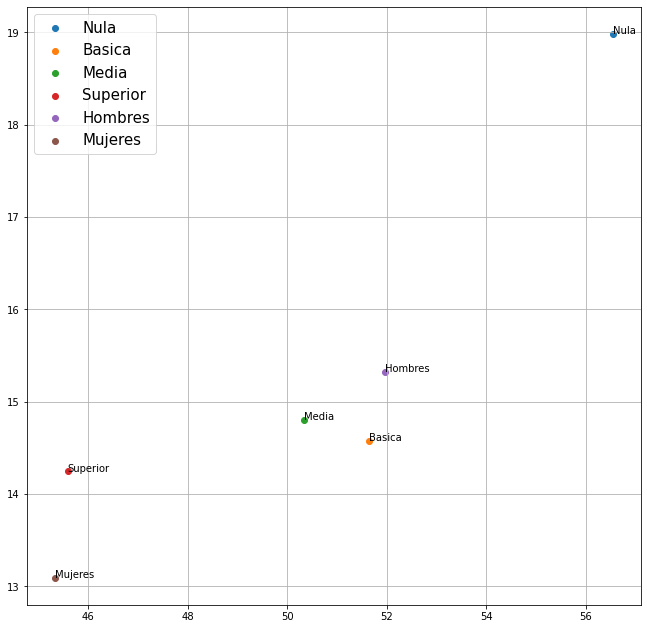

In [15]:
vec = [df_nula,df_basica,df_media,df_superior,df_hombres,df_mujeres]

x_s2_horas = arrEstimador(s2df,vec,'tot_horas')
x_s_horas = map(pow_n,x_s2_horas)
x_s_horas = list(x_s_horas)
x_media_horas = arrEstimador(np.mean,vec,'tot_horas')

legends = ['Nula','Basica','Media','Superior','Hombres','Mujeres']
plt.figure(figsize=(11,11))
for i in range(len(x_s2_horas)):
    plt.scatter(x_media_horas[i],x_s_horas[i])
    plt.annotate(legends[i], ( x_media_horas[i],x_s_horas[i]))
plt.legend(legends, fontsize="15")
plt.grid(True)

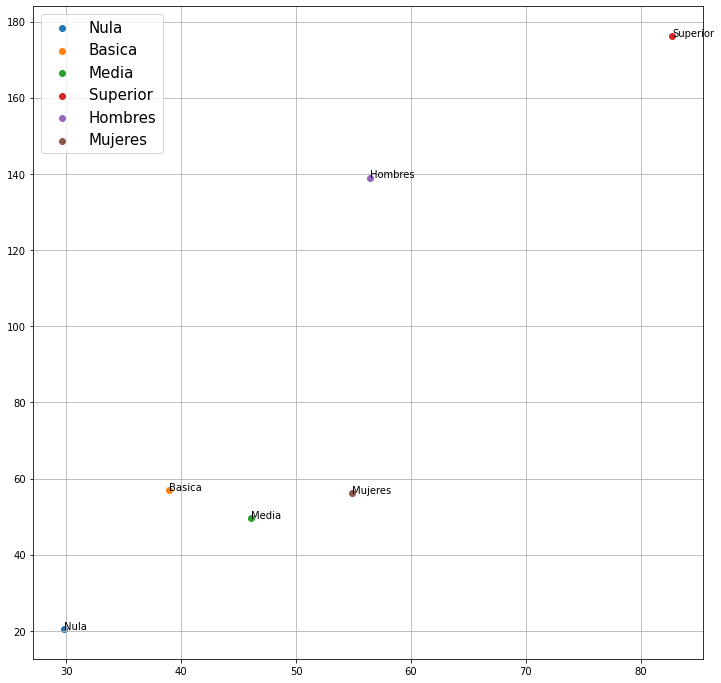

In [16]:
x_s2_ganancia = arrEstimador(s2df,vec,'ganancia_hora')
x_s_ganancia = map(pow_n,x_s2_ganancia)
x_s_ganancia = list(x_s_ganancia)
x_media_ganancia = arrEstimador(np.mean,vec,'ganancia_hora')

plt.figure(figsize=(12,12))
for i in range(len(x_s2_horas)):
    plt.scatter(x_media_ganancia[i],x_s_ganancia[i],label = legends[i])
    plt.annotate(legends[i], ( x_media_ganancia[i],x_s_ganancia[i]))
plt.legend(legends, fontsize="15")
plt.grid(True)

# Pruebas de hipotesis

### Probar si las personas por nivel educativo trabajan más que el promedio muestral

In [18]:
alfa = 0.001
h0 = 50

res = pruebaDeHipotesisSuperior(h0,df_nula['tot_horas'],alfa)

print('valor del punto crítico: ' + str(res[0]))
print('medias: ' + str(res[1]))
aceptar_o_rechazar_h0(res[2],alfa)

valor del punto crítico: 56.40977563986106
medias: 56.53932584269663
Hay evidencia suficiente para rechazar h0, con una confiabilidad del 0.999


## Agregar mas pruebas de hipotesis

In [22]:
df_hombres_nula = df_nula.loc[df_nula['SEXO'] == 1]
df_hombres_basica = df_basica.loc[df_basica['SEXO'] == 1]
df_hombres_media = df_media.loc[df_media['SEXO'] == 1]
df_hombres_superior = df_superior.loc[df_superior['SEXO'] == 1]
df_mujeres_nula = df_nula.loc[df_nula['SEXO'] == 2]
df_mujeres_basica = df_basica.loc[df_basica['SEXO'] == 2]
df_mujeres_media = df_media.loc[df_media['SEXO'] == 2]
df_mujeres_superior = df_superior.loc[df_superior['SEXO'] == 2]

# Numero de hombres por educacion en order creciente de educacion

In [25]:
print(len(df_hombres_nula))
print(len(df_hombres_basica))
print(len(df_hombres_media))
print(len(df_hombres_superior))

61
3374
2707
2436


# Numero de mujeres por educacion en order creciente de educacion

In [26]:
print(len(df_mujeres_nula))
print(len(df_mujeres_basica))
print(len(df_mujeres_media))
print(len(df_mujeres_superior))

28
1714
1788
2449


# Porcentaje de hombres por educacion en orden creciente de educacion

In [27]:
print(len(df_hombres_nula)/len(df_nula))
print(len(df_hombres_basica)/len(df_basica))
print(len(df_hombres_media)/len(df_media))
print(len(df_hombres_superior)/len(df_superior))

0.6853932584269663
0.66312893081761
0.6022246941045606
0.49866939611054245


In [28]:
print(len(df_mujeres_nula)/len(df_nula))
print(len(df_mujeres_basica)/len(df_basica))
print(len(df_mujeres_media)/len(df_media))
print(len(df_mujeres_superior)/len(df_superior))

0.3146067415730337
0.33687106918238996
0.39777530589543936
0.5013306038894575
